# Convolutional Neural Networks, Transfer Learning, and Adversarial Attacks

This notebook provides explanations, visualizations, and hands-on exercises to help you understand key concepts in modern deep learning for computer vision. We'll cover:

1. **Convolutional Neural Networks (CNNs)** - Understanding the fundamental building blocks and operations
2. **Transfer Learning** - Leveraging pre-trained models for new tasks
3. **Adversarial Attacks** - Exploring vulnerabilities in neural networks

Each section contains both theoretical explanations and practical coding exercises to reinforce your understanding.

In [1]:
#!pip install torch
#!pip install torchvision

In [2]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## Part 1: Convolutional Neural Networks (CNNs)

### 1.1 Understanding Convolution Operations

Convolutional Neural Networks (CNNs) are designed to efficiently process grid-like data such as images. The key innovation is the **convolution operation**, which applies filters across the input to detect features.

Key advantages of CNNs for image processing:
- **Preserve spatial structure** - 2D arrangement of pixels is maintained
- **Local receptive fields** - Each neuron only looks at a small region of the input
- **Parameter sharing** - The same filter is applied across the entire image
- **Translation invariance** - Features detected in one part of the image can be detected anywhere

Let's implement a simple 2D convolution operation from scratch to understand how it works:

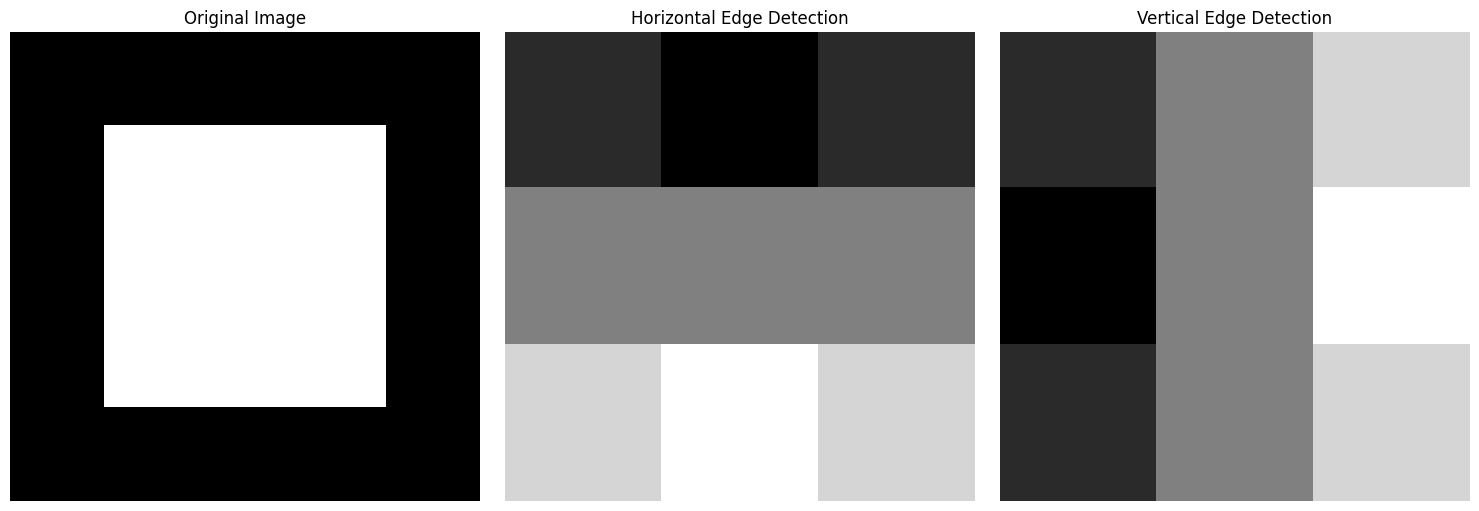

In [3]:
def conv2d_simple(input_image, kernel, stride=1, padding=0):
    """
    Implement a simple 2D convolution operation
    
    Args:
        input_image: 2D numpy array (height, width)
        kernel: 2D numpy array (kernel_height, kernel_width)
        stride: Step size for moving the kernel
        padding: Number of zeros to add around the input image
        
    Returns:
        2D numpy array containing the convolution result
    """
    # Get dimensions
    input_height, input_width = input_image.shape
    kernel_height, kernel_width = kernel.shape
    
    # Apply padding if needed
    if padding > 0:
        padded_image = np.pad(input_image, pad_width=padding, mode='constant')
    else:
        padded_image = input_image
        
    # Recalculate dimensions after padding
    padded_height, padded_width = padded_image.shape
    
    # Calculate output dimensions
    output_height = (padded_height - kernel_height) // stride + 1
    output_width = (padded_width - kernel_width) // stride + 1
    
    # Initialize output
    output = np.zeros((output_height, output_width))
    
    # Perform convolution
    for i in range(0, output_height):
        for j in range(0, output_width):
            # Extract the region of interest
            roi = padded_image[i*stride:i*stride+kernel_height, j*stride:j*stride+kernel_width]
            # Element-wise multiplication and sum
            output[i, j] = np.sum(roi * kernel)
            
    return output

# Create a simple 5x5 image
image = np.array([
    [0, 0, 0, 0, 0],
    [0, 1, 1, 1, 0],
    [0, 1, 1, 1, 0],
    [0, 1, 1, 1, 0],
    [0, 0, 0, 0, 0]
])

# Define some kernels
# Horizontal edge detection
horizontal_edge_kernel = np.array([
    [1, 1, 1],
    [0, 0, 0],
    [-1, -1, -1]
])

# Vertical edge detection
vertical_edge_kernel = np.array([
    [1, 0, -1],
    [1, 0, -1],
    [1, 0, -1]
])

# Apply convolutions
horizontal_output = conv2d_simple(image, horizontal_edge_kernel)
vertical_output = conv2d_simple(image, vertical_edge_kernel)

# Visualize results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(horizontal_output, cmap='gray')
axes[1].set_title('Horizontal Edge Detection')
axes[1].axis('off')

axes[2].imshow(vertical_output, cmap='gray')
axes[2].set_title('Vertical Edge Detection')
axes[2].axis('off')

plt.tight_layout()
plt.show()

### Task 1: Implement a Gaussian Blur Kernel

Create a Gaussian blur kernel and apply it to the image using the `conv2d_simple` function. A Gaussian kernel has higher values in the center and lower values toward the edges, following a Gaussian distribution.

**Hint**: You can use a 3x3 kernel with the following pattern:
```
[[1, 2, 1],
 [2, 4, 2],
 [1, 2, 1]]
```
Don't forget to normalize the kernel (divide by the sum of all elements) to preserve the brightness of the image.

In [4]:
# TODO: Implement a Gaussian blur kernel and apply it to the image
# 1. Create the Gaussian kernel
# 2. Normalize the kernel
# 3. Apply the convolution
# 4. Visualize the result

# Your code here


### 1.2 Convolution Size and Padding

When applying convolution operations, the output size changes based on the kernel size, stride, and padding. The formula for calculating the output size is:

$$\text{Output Size} = \frac{\text{Input Size} - \text{Kernel Size} + 2 \times \text{Padding}}{\text{Stride}} + 1$$

Let's explore how different parameters affect the output size:

In [5]:
def calculate_output_size(input_size, kernel_size, stride, padding):
    """
    Calculate the output size of a convolution operation
    """
    return (input_size - kernel_size + 2 * padding) // stride + 1

# Example: 32x32 input, 3x3 kernel
input_size = 32
kernel_size = 3

# Different stride and padding combinations
params = [
    (1, 0),  # stride=1, padding=0
    (1, 1),  # stride=1, padding=1
    (2, 0),  # stride=2, padding=0
    (2, 1),  # stride=2, padding=1
]

for stride, padding in params:
    output_size = calculate_output_size(input_size, kernel_size, stride, padding)
    print(f"Input: {input_size}x{input_size}, Kernel: {kernel_size}x{kernel_size}, Stride: {stride}, Padding: {padding} → Output: {output_size}x{output_size}")

Input: 32x32, Kernel: 3x3, Stride: 1, Padding: 0 → Output: 30x30
Input: 32x32, Kernel: 3x3, Stride: 1, Padding: 1 → Output: 32x32
Input: 32x32, Kernel: 3x3, Stride: 2, Padding: 0 → Output: 15x15
Input: 32x32, Kernel: 3x3, Stride: 2, Padding: 1 → Output: 16x16


### Task 2: Calculate Convolution Output Sizes

For each of the following scenarios, calculate the output size of the convolution operation:

1. Input: 28x28, Kernel: 5x5, Stride: 1, Padding: 0
2. Input: 224x224, Kernel: 7x7, Stride: 2, Padding: 3
3. Input: 64x64, Kernel: 3x3, Stride: 2, Padding: 1

Then, determine what padding value would be needed to maintain the same spatial dimensions (output size = input size) for an input of 32x32 with a 3x3 kernel and stride of 1.

In [6]:
# TODO: Calculate the output sizes for the given scenarios
# Then determine the padding needed to maintain spatial dimensions

# Your code here


### 1.3 Pooling Operations

Pooling layers reduce the spatial dimensions of the feature maps, which helps to:
- Reduce the number of parameters and computation
- Control overfitting
- Provide a form of translation invariance

The two most common pooling operations are:
- **Max Pooling**: Takes the maximum value from each window
- **Average Pooling**: Takes the average of all values in each window

Let's implement and visualize these pooling operations:

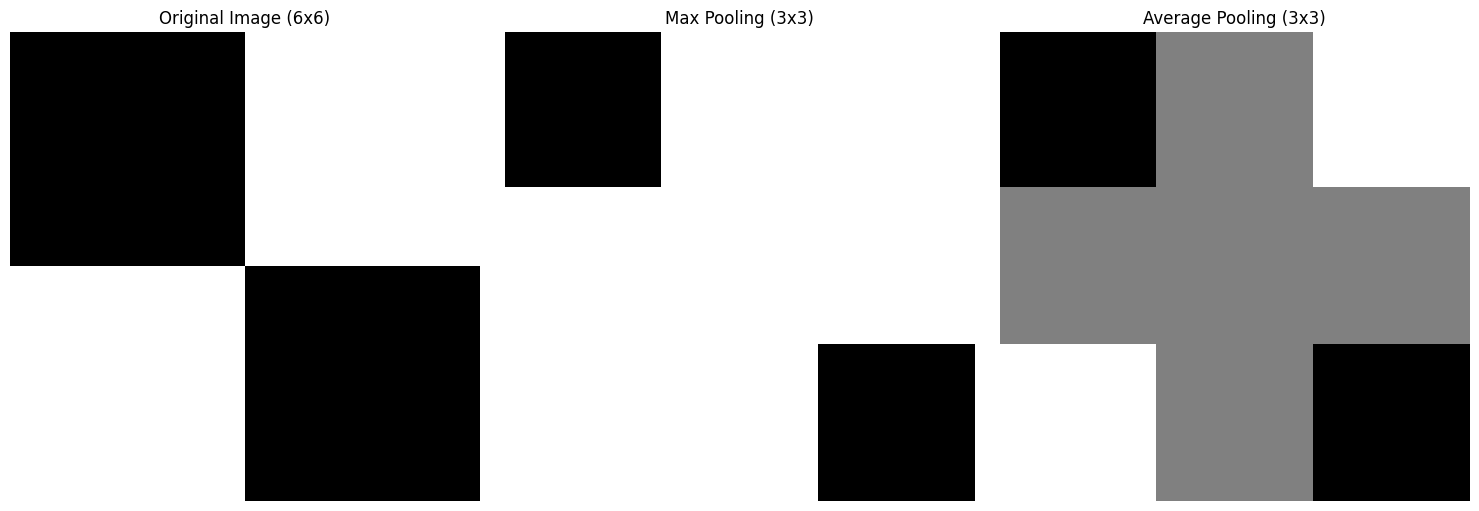

In [7]:
def max_pooling(input_image, pool_size=2, stride=2):
    """
    Implement max pooling operation
    """
    input_height, input_width = input_image.shape
    output_height = (input_height - pool_size) // stride + 1
    output_width = (input_width - pool_size) // stride + 1
    
    output = np.zeros((output_height, output_width))
    
    for i in range(output_height):
        for j in range(output_width):
            output[i, j] = np.max(input_image[i*stride:i*stride+pool_size, j*stride:j*stride+pool_size])
            
    return output

def avg_pooling(input_image, pool_size=2, stride=2):
    """
    Implement average pooling operation
    """
    input_height, input_width = input_image.shape
    output_height = (input_height - pool_size) // stride + 1
    output_width = (input_width - pool_size) // stride + 1
    
    output = np.zeros((output_height, output_width))
    
    for i in range(output_height):
        for j in range(output_width):
            output[i, j] = np.mean(input_image[i*stride:i*stride+pool_size, j*stride:j*stride+pool_size])
            
    return output

# Create a more complex 6x6 image
complex_image = np.array([
    [0, 0, 0, 1, 1, 1],
    [0, 0, 0, 1, 1, 1],
    [0, 0, 0, 1, 1, 1],
    [1, 1, 1, 0, 0, 0],
    [1, 1, 1, 0, 0, 0],
    [1, 1, 1, 0, 0, 0]
])

# Apply pooling operations
max_pooled = max_pooling(complex_image)
avg_pooled = avg_pooling(complex_image)

# Visualize results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(complex_image, cmap='gray')
axes[0].set_title('Original Image (6x6)')
axes[0].axis('off')

axes[1].imshow(max_pooled, cmap='gray')
axes[1].set_title('Max Pooling (3x3)')
axes[1].axis('off')

axes[2].imshow(avg_pooled, cmap='gray')
axes[2].set_title('Average Pooling (3x3)')
axes[2].axis('off')

plt.tight_layout()
plt.show()

### Task 3: Implement a CNN Layer

Now, let's combine what we've learned to implement a simple CNN layer that performs convolution followed by ReLU activation and max pooling. Use PyTorch's built-in functions for this task.

In [8]:
# TODO: Implement a CNN layer with convolution, ReLU, and max pooling
class SimpleCNNLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, pool_size=2):
        super(SimpleCNNLayer, self).__init__()
        # TODO: Initialize the convolution layer
        # TODO: Initialize the max pooling layer
        
    def forward(self, x):
        # TODO: Apply convolution
        # TODO: Apply ReLU activation
        # TODO: Apply max pooling
        return x

# Test your implementation
# Create a random 1x28x28 input tensor (simulating a grayscale image)
input_tensor = torch.randn(1, 1, 28, 28)

# TODO: Create an instance of your SimpleCNNLayer
# TODO: Pass the input tensor through your layer
# TODO: Print the output shape


### 1.4 Building a Complete CNN Architecture

Now let's build a complete CNN architecture for image classification. We'll use the MNIST dataset (handwritten digits) as an example.

A typical CNN architecture consists of:
1. **Convolutional layers** - Extract features from the input image
2. **Activation functions** - Introduce non-linearity (usually ReLU)
3. **Pooling layers** - Reduce spatial dimensions
4. **Fully connected layers** - Perform classification based on the extracted features

Let's implement a simple CNN for MNIST classification:

In [9]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # First convolutional layer
        # Input: 1x28x28, Output: 32x28x28
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        
        # First max pooling layer
        # Input: 32x28x28, Output: 32x14x14
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Second convolutional layer
        # Input: 32x14x14, Output: 64x14x14
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        
        # Second max pooling layer
        # Input: 64x14x14, Output: 64x7x7
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers
        # Input: 64*7*7 = 3136, Output: 128
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        
        # Output layer
        # Input: 128, Output: 10 (number of classes)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        # Apply first conv layer and ReLU activation
        x = F.relu(self.conv1(x))
        
        # Apply first pooling layer
        x = self.pool1(x)
        
        # Apply second conv layer and ReLU activation
        x = F.relu(self.conv2(x))
        
        # Apply second pooling layer
        x = self.pool2(x)
        
        # Flatten the tensor for the fully connected layer
        x = x.view(-1, 64 * 7 * 7)
        
        # Apply first fully connected layer and ReLU activation
        x = F.relu(self.fc1(x))
        
        # Apply output layer
        x = self.fc2(x)
        
        return x

# Create an instance of the model
model = SimpleCNN()
print(model)

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


Let's trace through the dimensions of a single image as it passes through our network:

In [10]:
# Create a random input tensor (batch_size=1, channels=1, height=28, width=28)
x = torch.randn(1, 1, 28, 28)

# Trace through the network
print(f"Input shape: {x.shape}")

# First conv layer
x = F.relu(model.conv1(x))
print(f"After conv1 + ReLU: {x.shape}")

# First pooling layer
x = model.pool1(x)
print(f"After pool1: {x.shape}")

# Second conv layer
x = F.relu(model.conv2(x))
print(f"After conv2 + ReLU: {x.shape}")

# Second pooling layer
x = model.pool2(x)
print(f"After pool2: {x.shape}")

# Flatten
x = x.view(-1, 64 * 7 * 7)
print(f"After flatten: {x.shape}")

# First fully connected layer
x = F.relu(model.fc1(x))
print(f"After fc1 + ReLU: {x.shape}")

# Output layer
x = model.fc2(x)
print(f"Output shape: {x.shape}")

Input shape: torch.Size([1, 1, 28, 28])
After conv1 + ReLU: torch.Size([1, 32, 28, 28])
After pool1: torch.Size([1, 32, 14, 14])
After conv2 + ReLU: torch.Size([1, 64, 14, 14])
After pool2: torch.Size([1, 64, 7, 7])
After flatten: torch.Size([1, 3136])
After fc1 + ReLU: torch.Size([1, 128])
Output shape: torch.Size([1, 10])


### Task 4: Modify the CNN Architecture

Modify the `SimpleCNN` architecture to include:
1. A third convolutional layer with 128 filters
2. Batch normalization after each convolutional layer
3. Dropout with a probability of 0.25 after the first fully connected layer

Then trace through the dimensions of a single image as it passes through your modified network.

In [11]:
# TODO: Implement the modified CNN architecture
class ModifiedCNN(nn.Module):
    def __init__(self):
        super(ModifiedCNN, self).__init__()
        # TODO: Implement the layers as described
        
    def forward(self, x):
        # TODO: Implement the forward pass
        return x

# TODO: Create an instance of your modified model
# TODO: Trace through the dimensions of a single image


### 1.5 Modern CNN Architectures

Over the years, several CNN architectures have been developed that have pushed the state-of-the-art in image classification:

1. **LeNet-5 (1998)** - One of the earliest CNNs, used for digit recognition
2. **AlexNet (2012)** - Winner of the 2012 ImageNet competition, popularized CNNs
3. **VGG (2014)** - Used small 3x3 filters throughout the network
4. **GoogLeNet/Inception (2014)** - Introduced the inception module with parallel convolutions
5. **ResNet (2015)** - Introduced residual connections to train very deep networks
6. **MobileNet (2017)** - Designed for mobile and embedded devices
7. **EfficientNet (2019)** - Scaled width, depth, and resolution in a principled way

Let's explore the concept of **residual connections** from ResNet, which was a breakthrough that allowed training much deeper networks:

In [12]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        # Second convolutional layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
            
    def forward(self, x):
        # Main path
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        
        # Add shortcut connection
        out += self.shortcut(x)
        out = F.relu(out)
        
        return out

# Create a simple ResNet-like model
class SimpleResNet(nn.Module):
    def __init__(self, num_blocks, num_classes=10):
        super(SimpleResNet, self).__init__()
        
        self.in_channels = 64
        
        # Initial convolution
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        
        # Residual blocks
        self.layer1 = self._make_layer(64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(256, num_blocks[2], stride=2)
        
        # Final fully connected layer
        self.linear = nn.Linear(256, num_classes)
        
    def _make_layer(self, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(ResidualBlock(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

# Create a small ResNet model
model = SimpleResNet([2, 2, 2])
print(model)

SimpleResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=

### Task 5: Explain Residual Connections

In your own words, explain why residual connections help with training very deep neural networks. What problem do they solve? How do they work?

Write your explanation in the cell below.

**Your explanation here:**




## Part 2: Transfer Learning

### 2.1 Understanding Transfer Learning

Transfer learning is a technique where a model trained on one task is repurposed for a related task. This is particularly useful in deep learning where:

1. Training large models from scratch requires massive amounts of data and computational resources
2. Lower layers of CNNs learn generic features (edges, textures) that are useful across many tasks
3. Only the higher layers need to be fine-tuned for specific tasks

The general approach to transfer learning with CNNs is:

1. Take a pre-trained model (e.g., trained on ImageNet)
2. Remove the final classification layer
3. Either:
   - Use the network as a feature extractor and train a new classifier on these features
   - Fine-tune some or all of the network's weights for the new task

Let's explore transfer learning using a pre-trained ResNet model:

In [13]:
# Load a pre-trained ResNet-18 model
resnet18 = models.resnet18(pretrained=True)

# Set the model to evaluation mode
resnet18.eval()

# Print the model architecture
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

/Users/mnorden/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mnorden/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Let's see how we can use this pre-trained model for a new classification task. We'll modify the final layer to classify a different number of classes:

In [14]:
def create_transfer_learning_model(num_classes, freeze_layers=True):
    """
    Create a transfer learning model based on ResNet-18
    
    Args:
        num_classes: Number of classes for the new task
        freeze_layers: Whether to freeze the weights of the pre-trained layers
        
    Returns:
        Modified ResNet-18 model
    """
    # Load pre-trained ResNet-18
    model = models.resnet18(pretrained=True)
    
    # Freeze the weights of the pre-trained layers if specified
    if freeze_layers:
        for param in model.parameters():
            param.requires_grad = False
    
    # Replace the final fully connected layer
    # ResNet-18's final layer has 512 input features
    model.fc = nn.Linear(512, num_classes)
    
    return model

# Create a transfer learning model for a 5-class classification problem
transfer_model = create_transfer_learning_model(num_classes=5, freeze_layers=True)

# Print the model architecture
print(transfer_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### 2.2 Feature Extraction vs. Fine-Tuning

There are two main approaches to transfer learning:

1. **Feature Extraction**: Freeze all layers except the final classification layer. The pre-trained network is used as a fixed feature extractor.

2. **Fine-Tuning**: After training with frozen layers, unfreeze some or all of the layers and continue training with a lower learning rate. This allows the pre-trained weights to be adjusted for the new task.

The choice between these approaches depends on:
- Size and similarity of the new dataset to the original dataset
- Available computational resources
- Risk of overfitting

Let's implement both approaches:

In [15]:
def train_feature_extraction(model, train_loader, val_loader, num_epochs=5):
    """
    Train a model using the feature extraction approach
    """
    # Move model to the appropriate device
    model = model.to(device)
    
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    
    # Only optimize the parameters of the final layer
    optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)
    
    # Training loop
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        # Print statistics
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}')
        
        # Validation phase
        model.eval()
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        print(f'Validation Accuracy: {100 * correct / total:.2f}%')
    
    return model

def train_fine_tuning(model, train_loader, val_loader, num_epochs=5):
    """
    Train a model using the fine-tuning approach
    """
    # First, train with feature extraction
    model = train_feature_extraction(model, train_loader, val_loader, num_epochs=2)
    
    # Then, unfreeze all layers and continue training with a lower learning rate
    for param in model.parameters():
        param.requires_grad = True
    
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    
    # Use a lower learning rate for fine-tuning
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    
    # Continue training
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        # Print statistics
        print(f'Fine-tuning Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}')
        
        # Validation phase
        model.eval()
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        print(f'Validation Accuracy: {100 * correct / total:.2f}%')
    
    return model

### Task 6: Transfer Learning Decision

For each of the following scenarios, decide whether you would use feature extraction, fine-tuning, or training from scratch, and explain your reasoning:

1. You have a dataset of 10,000 medical X-ray images and want to classify them into 5 disease categories. You have access to a pre-trained model on natural images (ImageNet).

2. You have a dataset of 1,000,000 natural images similar to ImageNet, but with 100 different classes.

3. You have a dataset of 500 satellite images and want to classify terrain types. You have access to a pre-trained model on natural images (ImageNet).

**Your answers here:**

1. 

2. 

3. 

## Part 3: Adversarial Attacks

### 3.1 Understanding Adversarial Attacks

Adversarial attacks are inputs specifically designed to fool neural networks while being imperceptible or nearly imperceptible to humans. These attacks reveal fundamental vulnerabilities in deep learning models.

Key concepts:
- **Adversarial examples**: Inputs with small, intentional perturbations that cause misclassification
- **White-box attacks**: Attacker has access to the model architecture and parameters
- **Black-box attacks**: Attacker only has access to the model's outputs
- **Targeted attacks**: Aim to make the model predict a specific incorrect class
- **Untargeted attacks**: Aim to make the model predict any incorrect class

Let's implement a simple adversarial attack called the Fast Gradient Sign Method (FGSM):

In [16]:
def fgsm_attack(model, image, label, epsilon=0.01):
    """
    Implement the Fast Gradient Sign Method (FGSM) attack
    
    Args:
        model: The model to attack
        image: The input image tensor
        label: The true label
        epsilon: The attack strength
        
    Returns:
        The perturbed image
    """
    # Move to device
    image = image.to(device)
    label = label.to(device)
    
    # Set requires_grad attribute of tensor
    image.requires_grad = True
    
    # Forward pass
    output = model(image)
    
    # Calculate loss
    loss = F.cross_entropy(output, label)
    
    # Zero all existing gradients
    model.zero_grad()
    
    # Calculate gradients of model in backward pass
    loss.backward()
    
    # Collect gradients
    data_grad = image.grad.data
    
    # Create the perturbed image by adjusting each pixel according to the sign of the gradient
    perturbed_image = image + epsilon * data_grad.sign()
    
    # Clamp the values to ensure they are in the valid range [0, 1]
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    
    return perturbed_image

Let's demonstrate this attack on a pre-trained model using a sample image:

Original prediction:
Great Pyrenees: 69.81%
kuvasz: 20.49%
golden retriever: 5.21%
standard poodle: 1.20%
Old English sheepdog: 0.68%


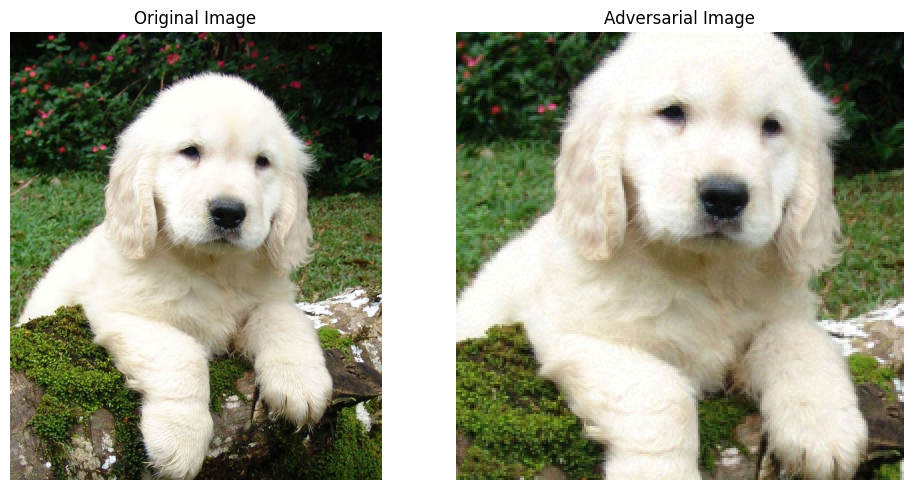


Adversarial prediction:
standard poodle: 84.08%
miniature poodle: 9.20%
toy poodle: 2.20%
cocker spaniel: 1.69%
Bedlington terrier: 1.20%


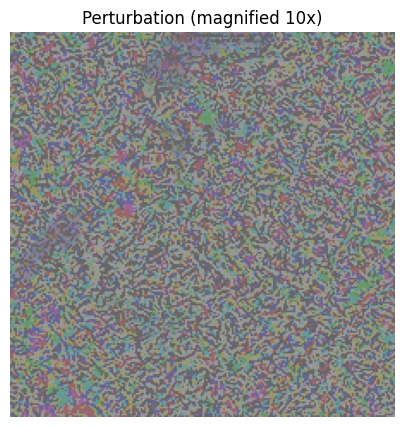

In [17]:
# Load a pre-trained model
model = models.resnet18(pretrained=True)
model = model.to(device)
model.eval()

# Define image preprocessing
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

# Load ImageNet class labels
with open('imagenet_classes.txt', 'r') as f:
    categories = [s.strip() for s in f.readlines()]

# Function to show prediction results
def predict_and_show(model, image_tensor):
    # Add batch dimension
    if image_tensor.dim() == 3:
        image_tensor = image_tensor.unsqueeze(0)
    
    # Move to device
    image_tensor = image_tensor.to(device)
    
    # Forward pass
    with torch.no_grad():
        output = model(image_tensor)
    
    # Get top predictions
    _, indices = torch.sort(output, descending=True)
    percentages = F.softmax(output, dim=1)[0] * 100
    
    # Print top 5 predictions
    for idx in indices[0][:5]:
        print(f"{categories[idx]}: {percentages[idx].item():.2f}%")
    
    return indices[0][0].item()

# Load and preprocess a sample image
image = Image.open('sample_image.jpg')
image_tensor = preprocess(image)

# Display the image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

# Get the original prediction
print("Original prediction:")
original_pred = predict_and_show(model, image_tensor)
original_label = torch.tensor([original_pred])

# Generate adversarial example
epsilon = 0.01
perturbed_image = fgsm_attack(model, image_tensor.unsqueeze(0), original_label, epsilon)

# Display the adversarial image
plt.subplot(1, 2, 2)
plt.imshow(perturbed_image[0].cpu().detach().permute(1, 2, 0))
plt.title('Adversarial Image')
plt.axis('off')
plt.tight_layout()
plt.show()

# Get the new prediction
print("\nAdversarial prediction:")
adversarial_pred = predict_and_show(model, perturbed_image)

# Display the perturbation
plt.figure(figsize=(5, 5))
perturbation = (perturbed_image[0] - image_tensor).cpu().detach()
# Scale the perturbation to make it visible
perturbation = perturbation * 10 + 0.5
perturbation = torch.clamp(perturbation, 0, 1)
plt.imshow(perturbation.permute(1, 2, 0))
plt.title('Perturbation (magnified 10x)')
plt.axis('off')
plt.show()

### 3.2 Defending Against Adversarial Attacks

Several methods have been proposed to defend against adversarial attacks:

1. **Adversarial Training**: Include adversarial examples in the training data
2. **Gradient Masking**: Make it harder for attackers to compute useful gradients
3. **Input Preprocessing**: Clean or transform inputs before feeding them to the model
4. **Model Ensemble**: Combine predictions from multiple models
5. **Certified Defenses**: Provide mathematical guarantees of robustness

Let's implement a simple defense using input preprocessing (Gaussian noise):

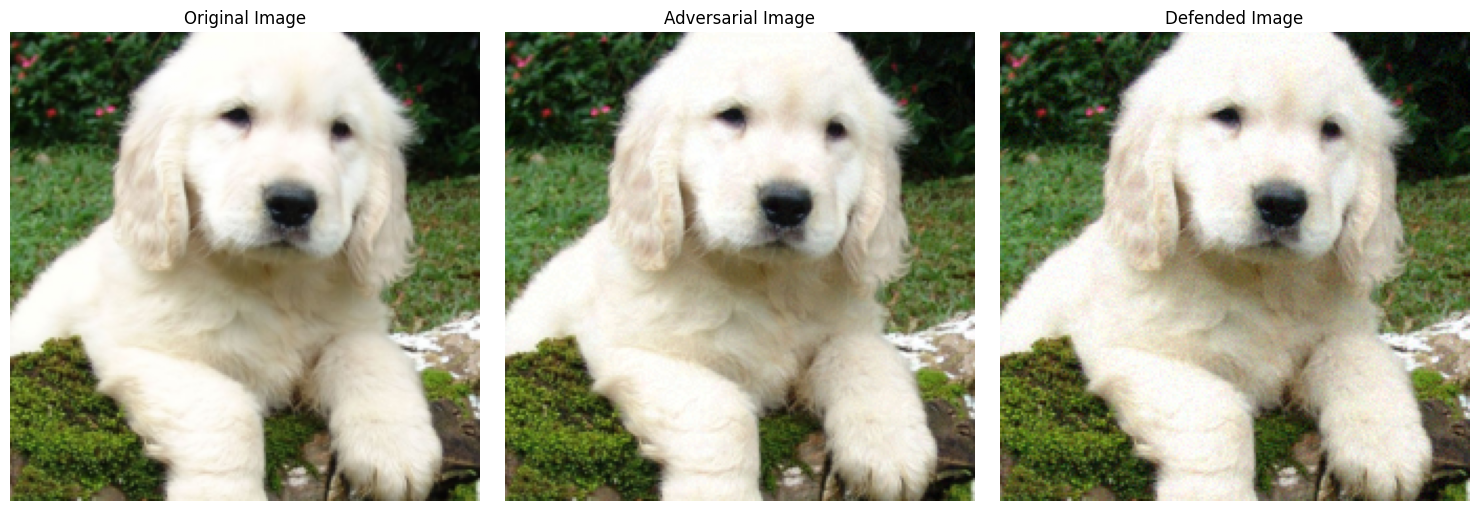

Defended image prediction:
standard poodle: 85.77%
miniature poodle: 7.91%
cocker spaniel: 1.86%
toy poodle: 1.73%
Bedlington terrier: 0.97%


In [18]:
def defend_with_noise(image, std=0.01):
    """
    Add Gaussian noise to the image as a defense against adversarial attacks
    
    Args:
        image: The input image tensor
        std: Standard deviation of the Gaussian noise
        
    Returns:
        The noisy image
    """
    # Create noise with the same shape as the image
    noise = torch.randn_like(image) * std
    
    # Add noise to the image
    noisy_image = image + noise
    
    # Clamp the values to ensure they are in the valid range [0, 1]
    noisy_image = torch.clamp(noisy_image, 0, 1)
    
    return noisy_image

# Apply the defense to the adversarial image
defended_image = defend_with_noise(perturbed_image, std=0.02)

# Display the defended image
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(image_tensor.permute(1, 2, 0))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(perturbed_image[0].cpu().detach().permute(1, 2, 0))
plt.title('Adversarial Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(defended_image[0].cpu().detach().permute(1, 2, 0))
plt.title('Defended Image')
plt.axis('off')

plt.tight_layout()
plt.show()

# Get the prediction for the defended image
print("Defended image prediction:")
defended_pred = predict_and_show(model, defended_image)

### Task 7: Implement a Targeted Adversarial Attack

Modify the FGSM attack to create a targeted attack that tries to make the model predict a specific target class. The loss function should maximize the probability of the target class instead of minimizing the probability of the true class.

In [19]:
# TODO: Implement a targeted FGSM attack
def targeted_fgsm_attack(model, image, target_label, epsilon=0.01, num_iterations=10):
    """
    Implement a targeted Fast Gradient Sign Method (FGSM) attack
    
    Args:
        model: The model to attack
        image: The input image tensor
        target_label: The target label to force the model to predict
        epsilon: The attack strength
        num_iterations: Number of iterations to run the attack
        
    Returns:
        The perturbed image
    """
    # TODO: Implement the targeted attack
    # Hint: Use negative loss to maximize the probability of the target class
    
    return perturbed_image

# TODO: Test your implementation
# 1. Choose a target class different from the original prediction
# 2. Apply your targeted attack
# 3. Verify that the model now predicts the target class


### Task 8: Adversarial Training

Implement a function that performs adversarial training by generating adversarial examples on-the-fly during training and including them in the training data. This is one of the most effective defenses against adversarial attacks.

In [20]:
# TODO: Implement adversarial training
def adversarial_training(model, train_loader, val_loader, num_epochs=5, epsilon=0.01):
    """
    Train a model with adversarial training
    
    Args:
        model: The model to train
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        num_epochs: Number of training epochs
        epsilon: The strength of the adversarial perturbation
        
    Returns:
        The trained model
    """
    # TODO: Implement adversarial training
    # Hint: For each batch, generate adversarial examples and train on both original and adversarial examples
    
    return model

# TODO: Test your implementation (if you have access to a dataset)


## Conclusion

In this notebook, we've explored three key topics in modern deep learning for computer vision:

1. **Convolutional Neural Networks (CNNs)** - We learned about the fundamental building blocks of CNNs, including convolution operations, pooling, and modern architectures like ResNet.

2. **Transfer Learning** - We explored how to leverage pre-trained models for new tasks, either through feature extraction or fine-tuning.

3. **Adversarial Attacks** - We implemented the FGSM attack and a simple defense, demonstrating the vulnerabilities of neural networks and how to address them.

These concepts are essential for understanding and working with deep learning models in computer vision applications. The tasks in this notebook have helped reinforce these concepts through hands-on implementation and theoretical analysis.

This notebook has been created with the help of ChatGPT-4, 08.07.2025; Explanations were initially generated and afterwards edited.